<a href="https://colab.research.google.com/github/1211236joaoco/aprau_16/blob/main/Group16_APRAU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Assignment - step 1** (Group 16)

# **Introduction**

This assignment applies different machine learning methods to a music–track dataset to **analyze**, **model**, and **interpret** results for both **regression** and **classification** tasks.

Each row of the dataset represents one track with rich audio/metadata features (e.g., **tempo**, **energy**, **movement**, **loudness**, **mood**, **duration** transforms, circular **key** encodings, etc.).  
We tackle two complementary prediction problems on the same music-track features.  
**Classification** answers *“what type is this track?”* by predicting a discrete class.  
**Regression** answers *“how much impact will it have?”* by estimating a continuous popularity score.


Two targets are provided:
- **`target_class`** — a *categorical* label (3 music classes for our group) → **classification**.  
- **`target_regression`** — a *continuous* popularity/impact score → **regression**.  



---

## **Analysis Plan**

### 1) Exploratory Data Analysis (EDA)
- **Descriptive Statistics:** duplicates/constant columns; for numerics: mean/median, std, p5–p95, IQR, min/max, **skewness**/**kurtosis**; for categoricals: **cardinality**, dominant and rare levels.  
- **Data types and missing values:** size and dtypes; missing values;
- **Univariate Analysis:** distributions of individual features  
  - Numeric → histograms/boxplots, outliers, zero inflation, need for transforms (e.g., `log1p`, Yeo–Johnson).  
  - Categorical → frequency bars (top-k), rare-level grouping, consistency of labels.  
- **Bivariate Analysis:** relationships  
  - Feature ↔ **`target_regression`** → Pearson/Spearman, scatter with trend.  
  - Feature ↔ **`target_class`** → box/violin by class, contingency tables, χ² / Cramér’s V.  
  - Feature ↔ feature → correlation heatmap, multicollinearity flags.

**Outcome:** a shortlist of informative features, preprocessing decisions (imputation, encoding, scaling, transformations), and risks (leakage, imbalance).

---

## **Modeling Tasks**

### 2) Regression — predict `target_regression`
- **Simple Linear Regression:** fit several single-feature models, compare, and **select the best feature**.
- **Multiple Linear Regression:** build models with **selected feature sets** (e.g., SelectKBest/Lasso or EDA-driven subsets).
- **Evaluation (hold-out):** report **R²**, **MAE**, **RMSE**; compare and discuss results.

### 3) Classification — predict `target_class`
- **Methods:** **Logistic Regression**, **LDA**, **QDA** (with appropriate preprocessing and class-imbalance handling).
- **Resampling (required):** **Holdout**, **k-fold CV (k=5, k=10)**, **LOOCV**, **Bootstrap**.  
- **Metrics (imbalanced setting):** emphasize **macro-F1** and **balanced accuracy**; include accuracy and (if probabilities used) ROC-AUC (OvR).  
- **Discussion:** compare methods and explain which is most suitable for this problem (assumptions, stability, variance).

---

## **Evaluation & Variance Discussion**
We will **quantify performance and variability** across resampling strategies:
- Holdout → fastest, higher variance.
- 5-fold vs **10-fold** CV → increasingly stable estimates.
- LOOCV → expensive and often high-variance.
- Bootstrap → mean ± std of metrics across resamples (uncertainty quantification).

---

> **Summary:** We will start with  rigorous EDA to understand the data and guide preprocessing, then build and evaluate regression and classification models using multiple resampling strategies, reporting both performance and variability to justify the final methodological choices.


In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

df = pd.read_csv('group_16.csv', sep=";")

#Information about dataset dimension
print("Dimension (lines, columns):", df.shape)


Dimension (lines, columns): (3000, 49)


#**Analysis Plan**

## *1.1 - Descriptive statistics*

---
### Descriptive Statistics

Descriptive statistics are the first, essential pass over a dataset to understand **"what we have"** before modeling or drawing conclusions. They summarize data without testing hypotheses.

**What we cover**
- **Central tendency**: mean and median
- **Dispersion**: standard deviation, quartiles, IQR, min and max
- **Distribution shape**: skewness and kurtosis
- **Categorical features**: cardinality and category frequencies

**Why this matters for our project**
- Exposes data-quality issues like duplicates, outliers, and inconsistent labels  
- Guides cleaning steps such as imputation, type fixes, and category grouping  
- Informs Univariate and Bivariate Analysis and the choice of transformations  
  - High skew in a numeric feature may suggest a log transform  
  - Many rare categories may need consolidation  
  - Large dispersion or extreme values may call for robust methods

By documenting these summaries in our repo with small tables and brief notes, we create a reproducible baseline that justifies preprocessing decisions and ensures every teammate starts from the same, well-understood dataset.


In [2]:
# Generate descriptive statistics of the numerical columns
print("\nNumeric columns:")
df.describe()


Numeric columns:


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,...,loudness_yeo,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_regression
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.0,3000.000000,3000.000000,3000.000000
mean,0.037000,0.149333,0.340000,0.468000,0.005667,1.681000,1.693000,1.019000,0.086987,0.052363,...,0.205213,0.002000,0.002000,-0.008336,-0.011632,0.489889,1.0,0.010426,0.659147,-0.412907
std,0.188793,0.356476,0.473788,0.499058,0.075076,1.338097,1.044564,0.280473,0.786029,1.011637,...,0.760864,0.044684,0.044684,0.985782,0.992020,0.287163,0.0,1.000689,0.183644,1.036746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.712656,-1.511882,...,-2.454420,0.000000,0.000000,-2.931645,-3.360448,0.000002,1.0,-3.266071,0.000071,-1.490205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.221824,-0.920961,...,-0.285878,0.000000,0.000000,-0.870603,-0.699904,0.241753,1.0,-0.615416,0.537000,-1.400539
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.221824,0.176466,...,0.239894,0.000000,0.000000,-0.073993,-0.001784,0.485246,1.0,0.087583,0.682000,-0.862540
75%,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,3.000000,1.000000,0.221824,1.020640,...,0.705554,0.000000,0.000000,0.654392,0.663309,0.732659,1.0,0.756009,0.803000,0.437625
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,2.533318,1.611562,...,5.666622,1.000000,1.000000,3.064761,3.705243,0.999930,1.0,2.409787,0.989000,2.903456


In [3]:
# Generate descriptive statistics of the categorical columns
df_categorical_cols = df.select_dtypes(exclude= np.number).copy()

print("\nCategoric columns:")
print(df_categorical_cols.describe())


Categoric columns:
       focus_factor target_class
count          3000         3000
unique          992            3
top             0.0     class_68
freq           1499         1000


## 1.2 Data types & missing values

We identified **data types** (numeric, categorical) to ensure correct preprocessing (scaling/transformations for numerics, encoding for categoricals).


In [27]:
# Check data types and missing values
data_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Unique Values': df.nunique(),
})

data_info['Non-null Count'] = len(df) - data_info['Missing Values']

data_info

,Data Type,Missing Values,Unique Values,Non-null Count
duration_1,float64,0,2,3000
duration_2,float64,0,2,3000
duration_3,float64,0,2,3000
duration_4,float64,0,2,3000
duration_5,float64,0,2,3000
loudness_level,float64,0,5,3000
popularity_level,float64,0,5,3000
tempo_class,float64,0,5,3000
time_signature,float64,0,4,3000
key_mode,float64,0,24,3000


## *2 - Univariate Analysis*

---

Univariate analysis examines one variable at a time to understand its distribution before any modeling. For **numeric** features we look at histograms and density. For **categorical** features we review dominant categories.  
**Why it matters for our project:** it reveals issues that affect preprocessing and modeling choices. Highly skewed numeric features may need a log transform or robust methods. Zero-inflated variables may benefit from indicator features. Categorical features with many rare levels should be consolidated or encoded with target encoding rather than naive one-hot. The goal is to decide cleaning, transformations, and encoding strategies feature by feature.
Guided by the descriptive statistics, we filtered out non-informative fields (constant/near-constant variables) and any columns with potential leakage. We then prioritized for univariate analysis those numeric features showing high skew or dispersion and categorical features with substantial cardinality, dominant classes, or notable missing rates.


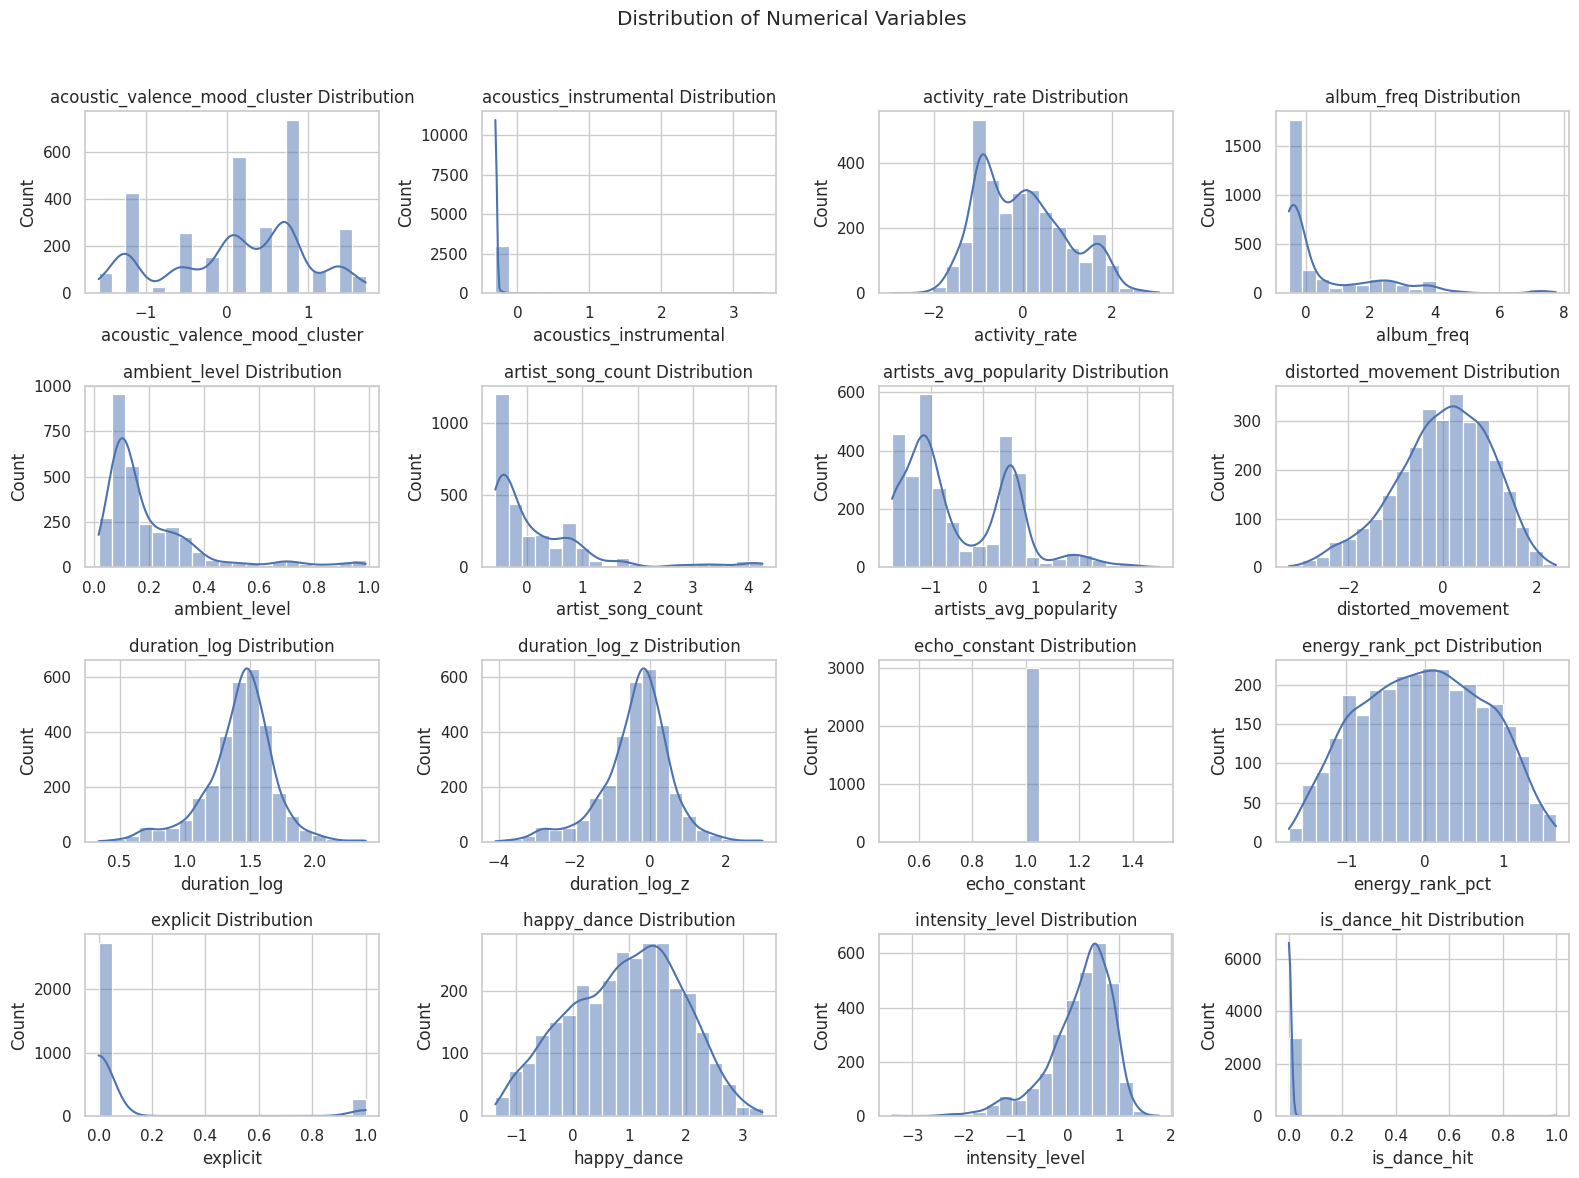

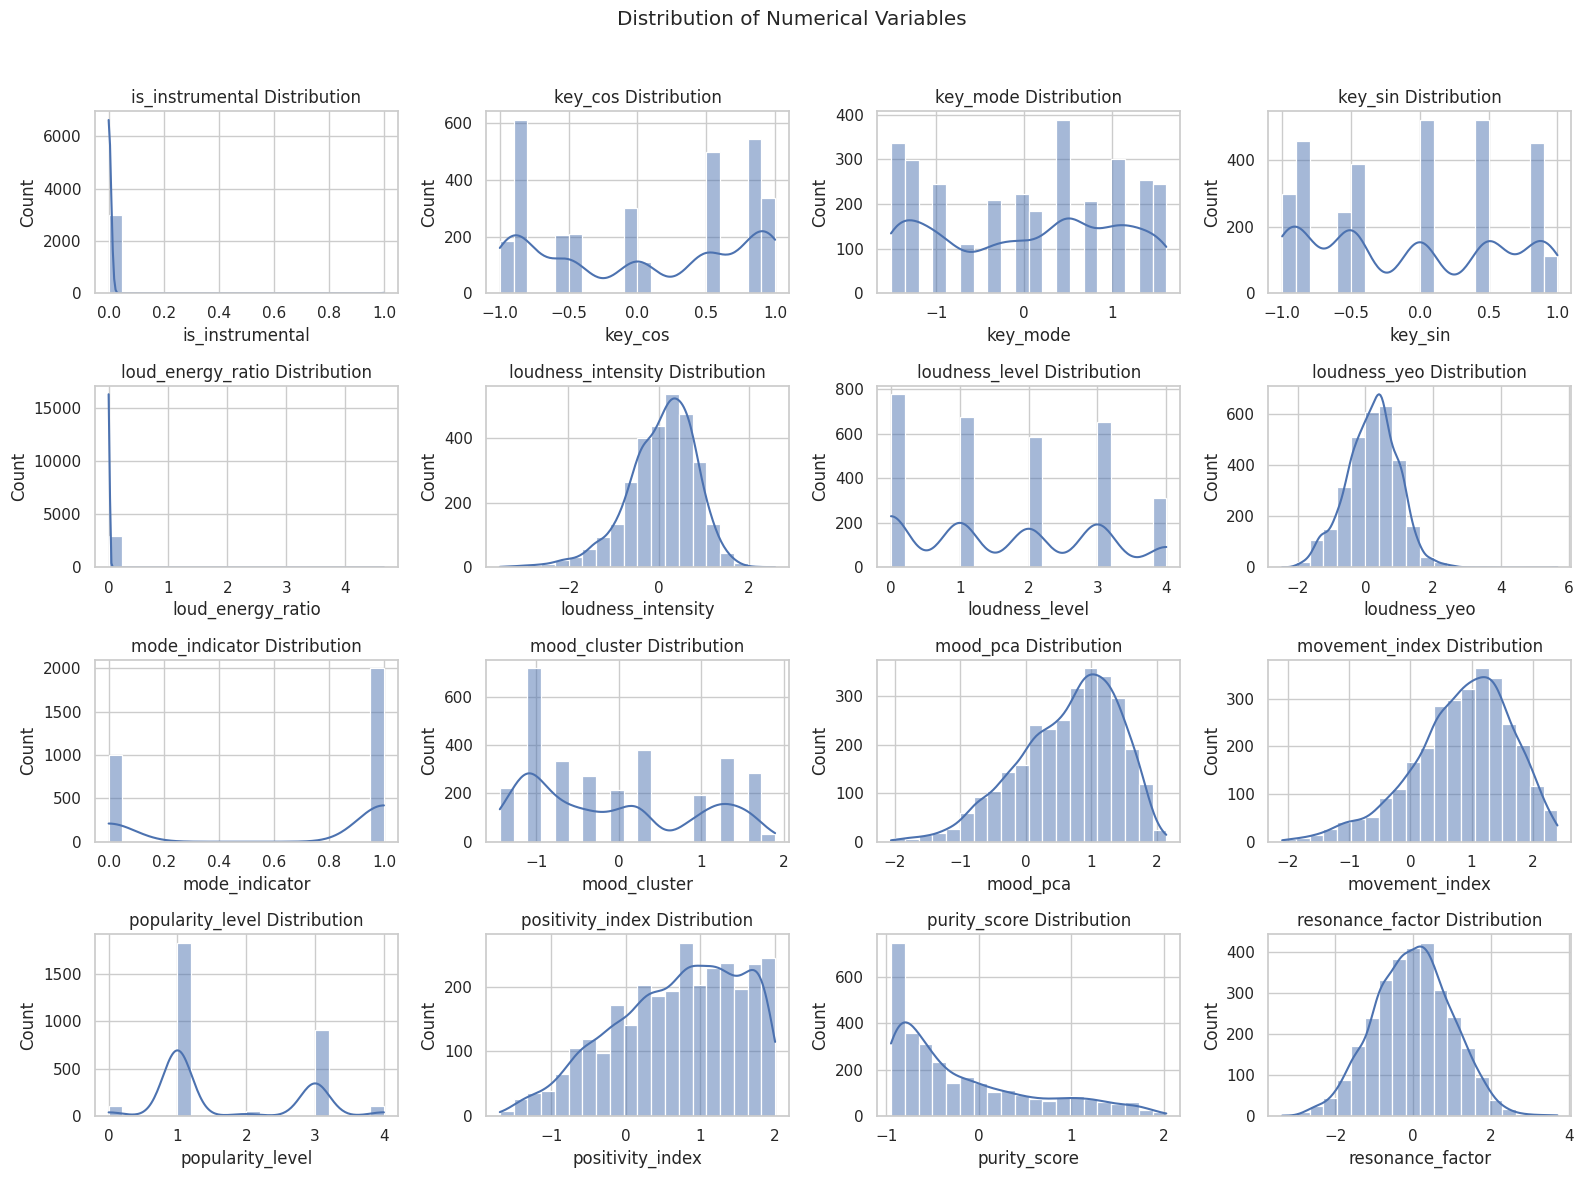

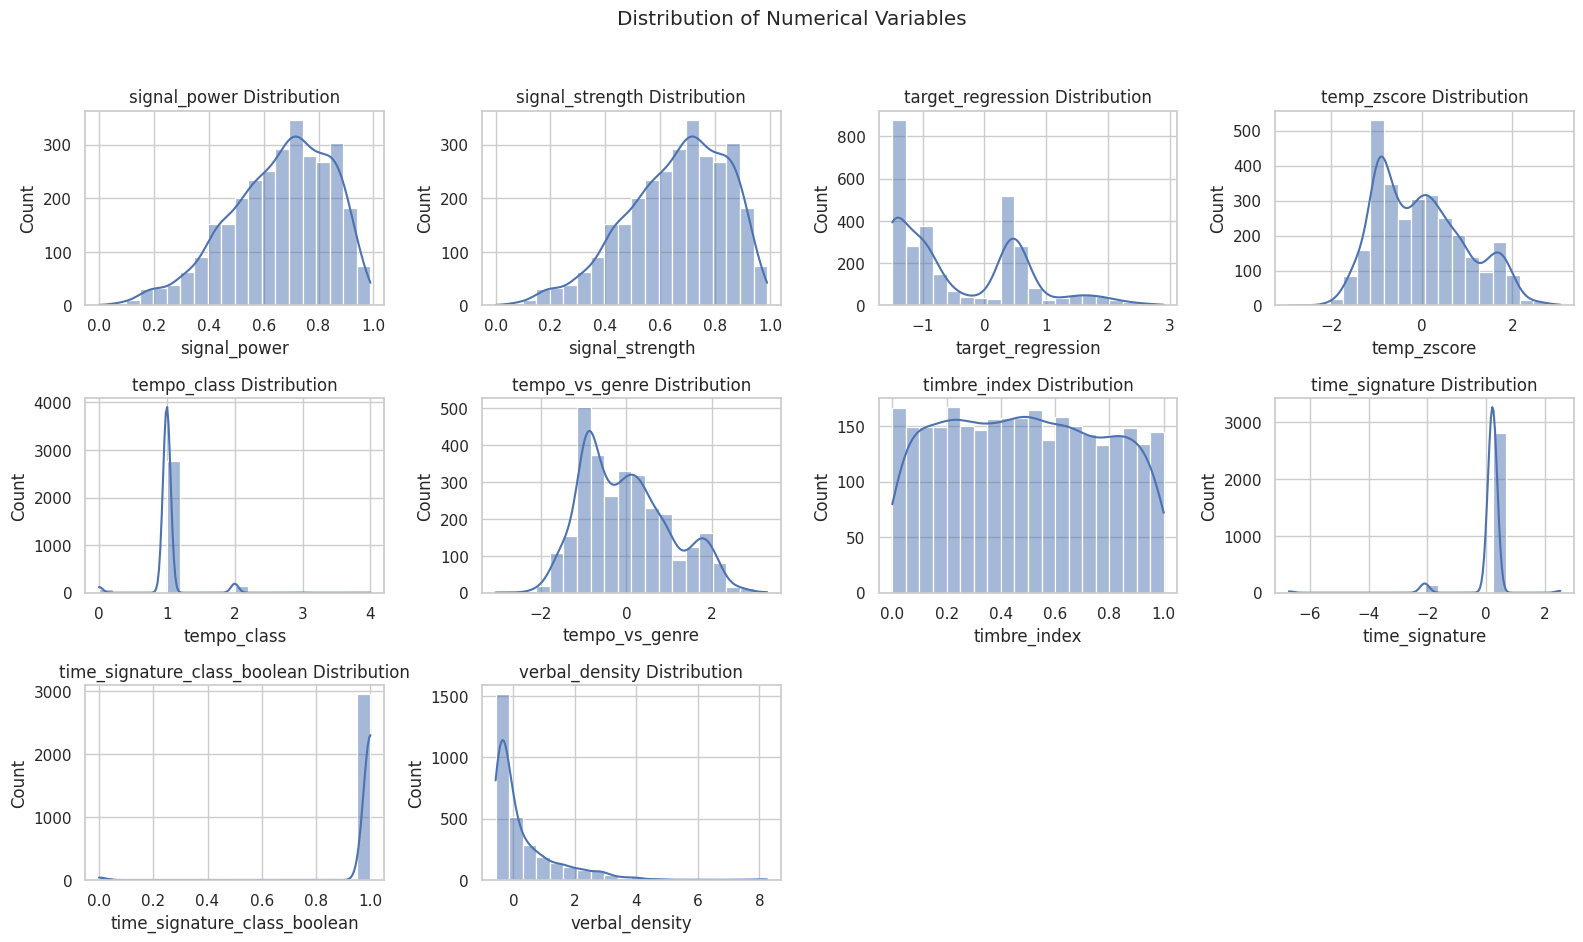

In [5]:
sns.set(style="whitegrid")

# Defines the numeric columns
num_cols = df.select_dtypes(include=np.number).columns
num_cols_hist = num_cols.difference(['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5'])

# "for" to run all the numeric columns and create the graphic
# grid of 2x2, 4 columns at a time
for i in range(0, len(num_cols_hist), 16):
    cols = num_cols_hist[i:i+16]

    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle('Distribution of Numerical Variables')

    axes = axes.flatten()
    for ax, col in zip(axes, cols):
        sns.histplot(df[col].dropna(), kde=True, bins=20, ax=ax)
        ax.set_title(f'{col} Distribution')

    for k in range(len(cols), 16):
        fig.delaxes(axes[k])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

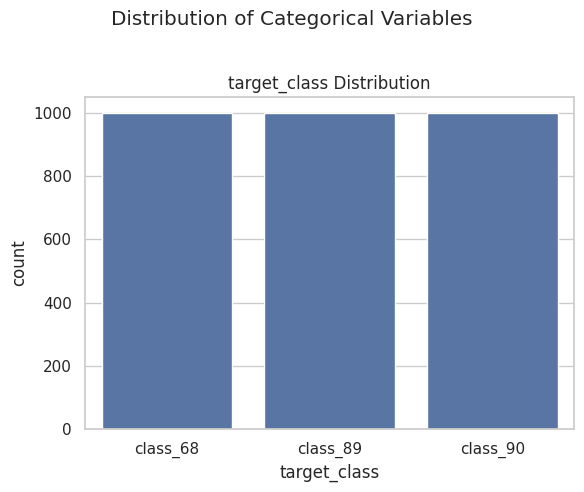

In [17]:
# Plot bar plots for categorical variables
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
fig.suptitle('Distribution of Categorical Variables')

sns.countplot(x='target_class', data=df, ax=axes)
axes.set_title('target_class Distribution')

# sns.countplot(x='focus_factor', data=df, ax=axes[1])
# axes[1].set_title('focus_factor Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## *3 - Bivariate Analysis*

---
Bivariate analysis studies relationships between **two variables**, especially **individual features** and **target variable**.  
For a comparison of **numeric** variables, we use scatter plots and correlation (Pearson for linear, Spearman for monotonic) to spot strength, direction, nonlinearity, and multicollinearity.  
Our numeric target variable is **`target_regression`**, that represents the music record's popularity or impact through a numerical score.
For this first bivariate analysis we used **scatter plots**: graphs that use dots to represent the values of two variables, showing the relationship between them.

In [20]:
# # Plot scatter plots for numerical variables vs charges
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# fig.suptitle('Scatter Plots of Numerical Variables vs Charges')

# sns.scatterplot(x='age', y='charges', data=df, ax=axes[0])
# axes[0].set_title('Age vs Charges')

# sns.scatterplot(x='bmi', y='charges', data=df, ax=axes[1])
# axes[1].set_title('BMI vs Charges')

# sns.scatterplot(x='children', y='charges', data=df, ax=axes[2])
# axes[2].set_title('Children vs Charges')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

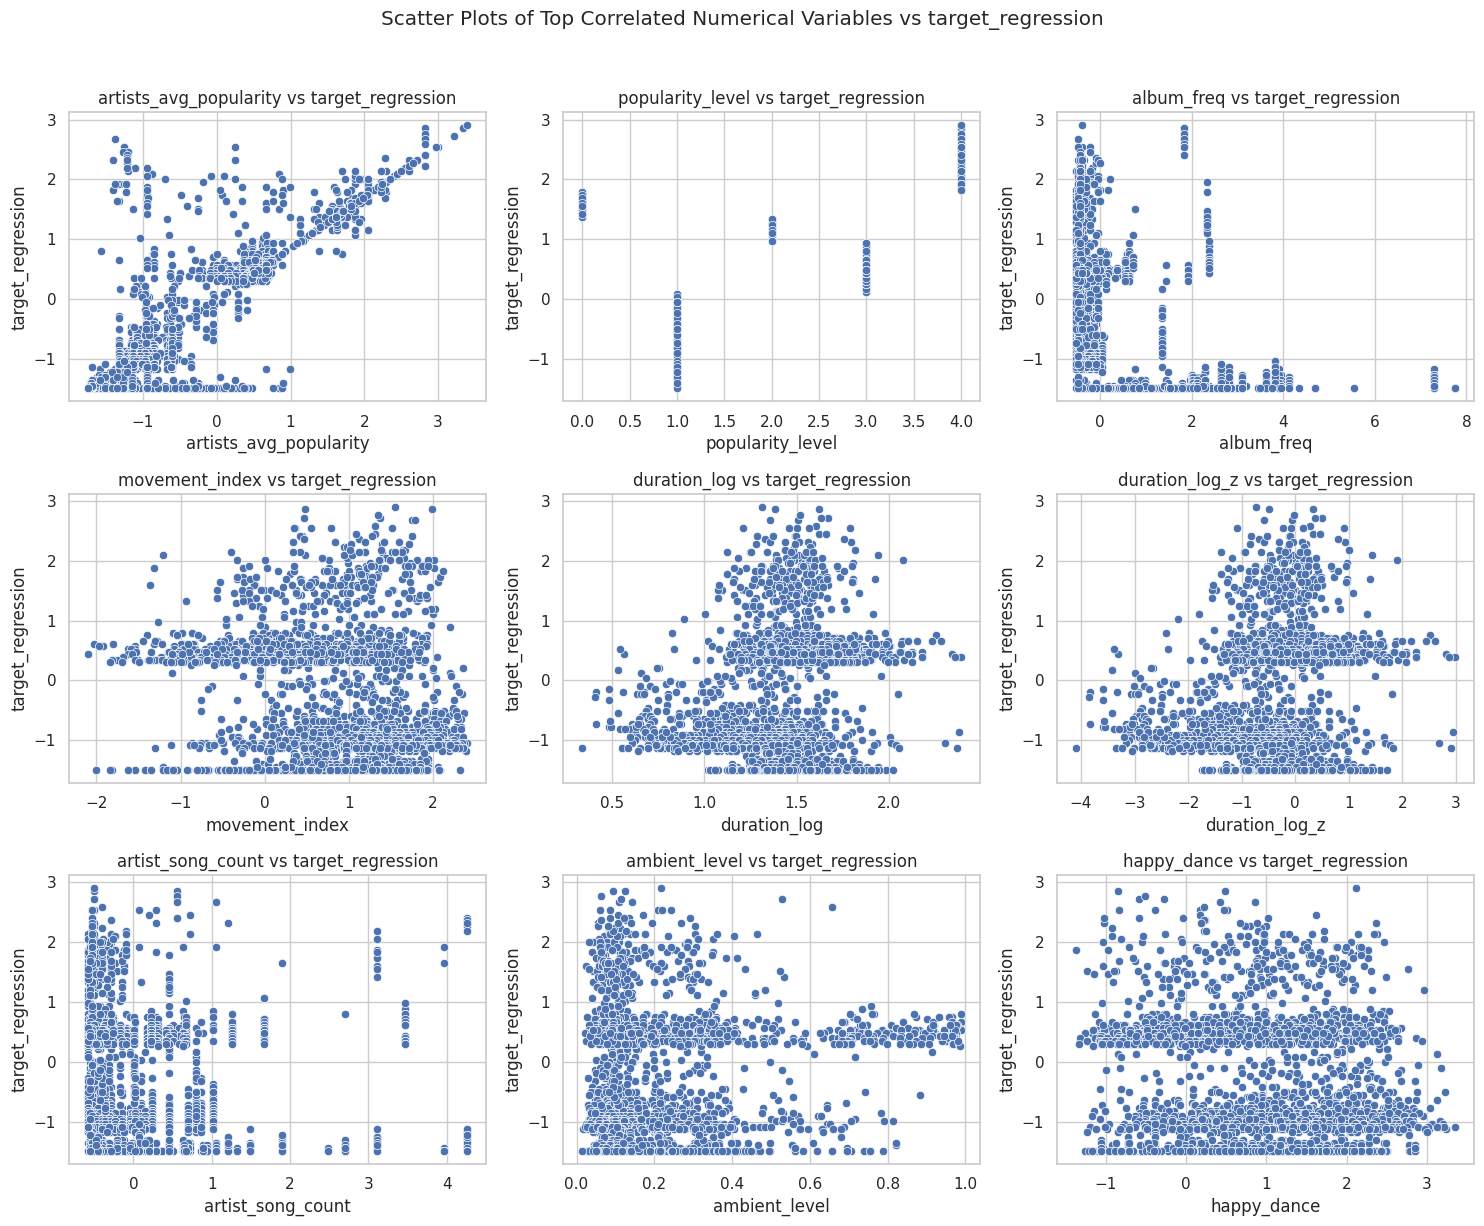

In [23]:
# Select numerical columns excluding the target variable
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('target_regression')

# Calculate and display the correlation matrix for numerical columns and target_regression
correlation_matrix = df[numerical_cols + ['target_regression']].corr()
# print("Correlation Matrix (Numerical columns vs target_regression):")
# display(correlation_matrix['target_regression'].sort_values(ascending=False))

# Plot scatter plots for a selection of numerical variables vs target_regression
# Selecting top 9 correlated features for visualization
top_correlated_features = correlation_matrix['target_regression'].abs().sort_values(ascending=False).head(10).index.tolist()
top_correlated_features.remove('target_regression') # Remove the target itself

n_cols = 3
n_rows = (len(top_correlated_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
fig.suptitle('Scatter Plots of Top Correlated Numerical Variables vs target_regression', y=1.02)
axes = axes.flatten()

for i, col in enumerate(top_correlated_features):
    sns.scatterplot(x=col, y='target_regression', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs target_regression')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('target_regression')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


For **numeric ↔ categorical**, we compare distributions across groups with box plots.  
A box plot is a visual representation of a dataset's distribution, displaying the five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum
**Why it matters for our project:** it highlights predictive signals, warns about redundant features, and guides modeling. Strong yet nonlinear patterns suggest splines or tree-based models. High correlation between features flags multicollinearity to control with feature selection or regularization. Group differences in the target validate useful splits and inform encoding and feature engineering.



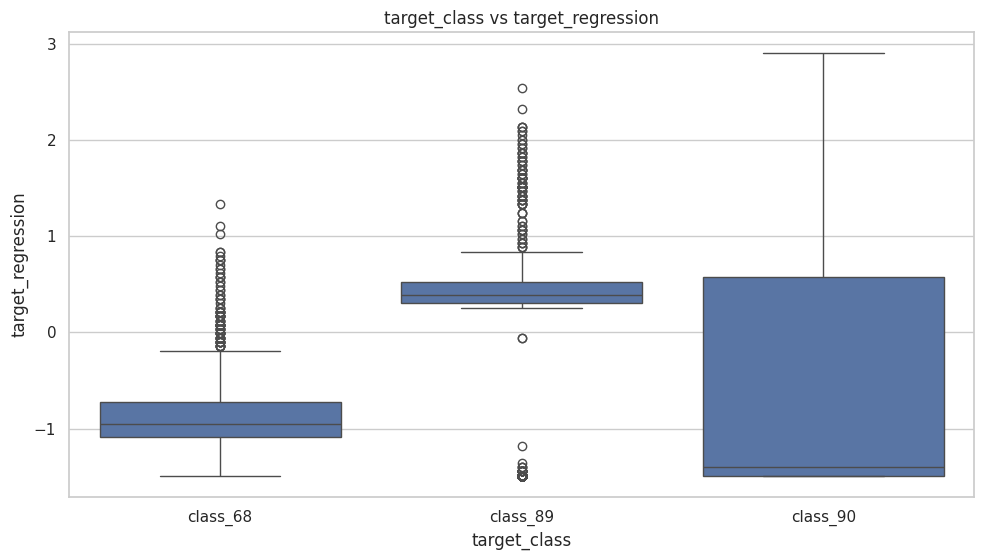

In [26]:
# Plot box plots for categorical variables vs charges
fig, axe = plt.subplots(1, 1, figsize=(10, 6))

sns.boxplot(x='target_class', y='target_regression', data=df, ax=axe)
axe.set_title('target_class vs target_regression')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**target_class vs target_regression**

The distributions don't completely overlap. `class_68` is mostly associated with low `target_regression`, `class_89` tends to sit higher with a tighter spread, and `class_90` is very wide and mixed — which means `target_class` carries signal about the target and should help the regression model.

